# MANUela Anomaly ML Model

Goal: Build a machine lerning model that detects anomalies in sensor vibration data

![anomalies](https://raw.githubusercontent.com/sa-mw-dach/manuela/master/docs/images/manuela-anomalies.png)

Steps:
- Wrangling sensor data 
- Save the training data
- Prepare the data for modeling, training and testing
- Train and validate models
- Select and save the best model
- Prototype class for Seldon model serving

*Note: This is an extension of the initial notebook, where Deep Learning Model (LSTM Autoencoder) has been introduced.*

### Table of Contents

* [Chapter 1: Explore sensor data](#chapter1)
    * [Section 1.1: Preview the raw data](#section_1_1)
    * [Section 1.2: Visualize raw data over time](#section_1_2) 
    * [Section 1.3: Visualize labeled data over time](#section_1_3)
* [Chapter 2: Data Wrangling](#chapter2)
    * [Section 1.1: Explore the new data](#section_2_1)
    * [Section 1.2: Save Training data to CSV](#section_2_2) 
* [Chapter 3: Data Preparation](#chapter3)
    * [Section 1.1: Training and Testing Data Split](#section_3_1)
    * [Section 1.2: Identify feature and target columns](#section_3_2)


## Import libraries and define methods

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Statistical ML Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# ML Framework and High Level API
import tensorflow as tf
from tensorflow import keras

from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

## Explore sensor data  <a class="anchor" id="chapter1"></a>

In [2]:
# Retrieve data
df = pd.read_csv('raw-data.csv')

# Set time as index
df['time'] = pd.to_datetime(df['ts'],unit='ms')
df.set_index('time', inplace=True)
df.drop(columns=['ts'], inplace=True)

### Preview the raw data   <a class="anchor" id="section_1_1"></a>

In [3]:
df.head(20)

,id,value,label
time,,,
2020-04-23 11:13:54.617,pump-1,18.340181,0
2020-04-23 11:13:57.999,pump-2,12.703972,0
2020-04-23 11:13:59.618,pump-1,17.647661,0
2020-04-23 11:14:02.999,pump-2,13.805114,0
2020-04-23 11:14:04.617,pump-1,16.874933,0
2020-04-23 11:14:07.999,pump-2,15.415206,0
2020-04-23 11:14:09.617,pump-1,16.180807,0
2020-04-23 11:14:12.999,pump-2,15.922729,0
2020-04-23 11:14:14.618,pump-1,15.407113,0


In [4]:
df.describe()

,value,label
count,3022.000000,3022.000000
mean,14.433740,0.027796
std,4.539839,0.164416
min,8.089854,0.000000
25%,11.725275,0.000000
50%,13.975456,0.000000
75%,16.180843,0.000000
max,48.423213,1.000000


<AxesSubplot:xlabel='value'>

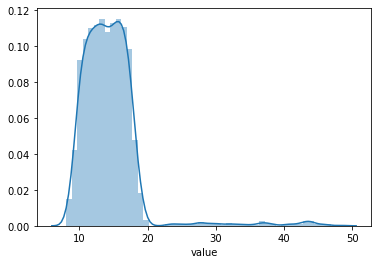

In [5]:
sns.distplot(df['value'].dropna())

In [6]:
printmd(f"Data collected between **{min(df.index)}** and **{max(df.index)}**: **{df.shape[0]}** samples from 2 pumps.")
total_time = max(df.index) - min(df.index)
printmd(f"Total time: **{total_time}**")

printmd(f"Time between samples: **{(total_time.seconds/df.loc[(df['id'] == 'pump-1')].shape[0])}** s")

for pump in df['id'].unique():
    printmd(f"There are **{df.loc[df['id'] == pump].shape[0]}** samples for **{pump}**")

Data collected between **2020-04-23 11:13:54.617000** and **2020-04-23 13:19:47.999000**: **3022** samples from 2 pumps.

Total time: **0 days 02:05:53.382000**

Time between samples: **4.9986763732627395** s

There are **1511** samples for **pump-1**

There are **1511** samples for **pump-2**

### Visualize raw data over time   <a class="anchor" id="section_1_2"></a>

All data

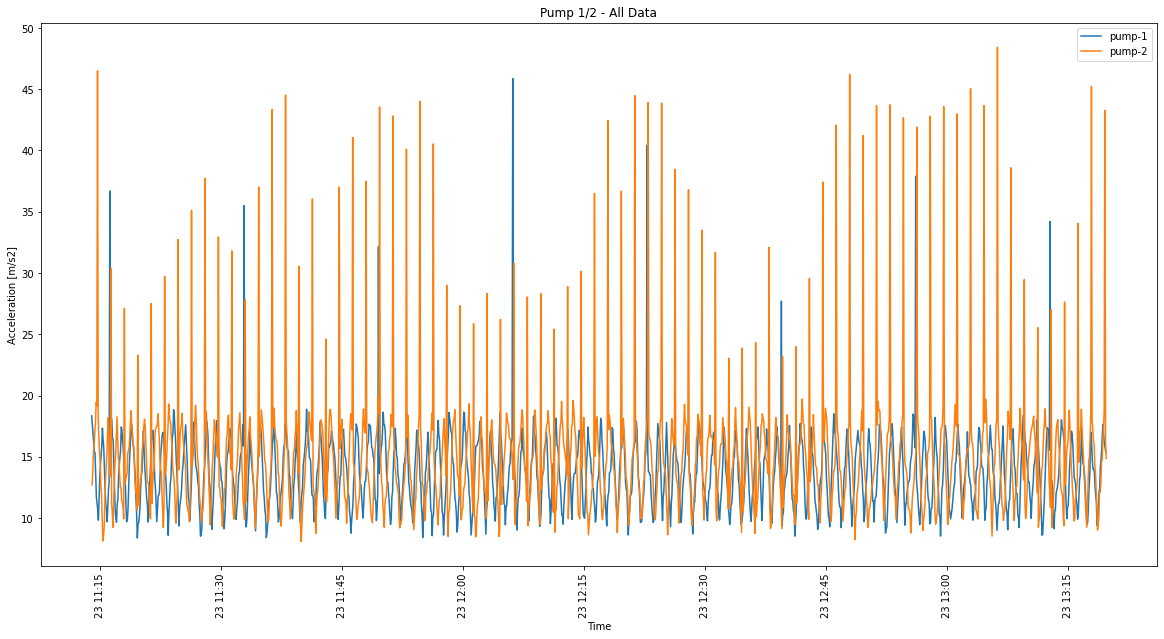

In [7]:
fig= plt.figure(figsize=(20,10))

for pump in df['id'].unique():
    y = df.loc[(df['id'] == pump)]
    df_time = [pd.to_datetime(t) for t in y.index]
    plt.plot(df_time, y["value"].values, label=pump)

plt.legend()
plt.title("Pump 1/2 - All Data")
plt.xlabel("Time")
plt.xticks(rotation=90)
plt.ylabel("Acceleration [m/s2]")
plt.show()

Vibration pump 1: Data shows a few anomalies

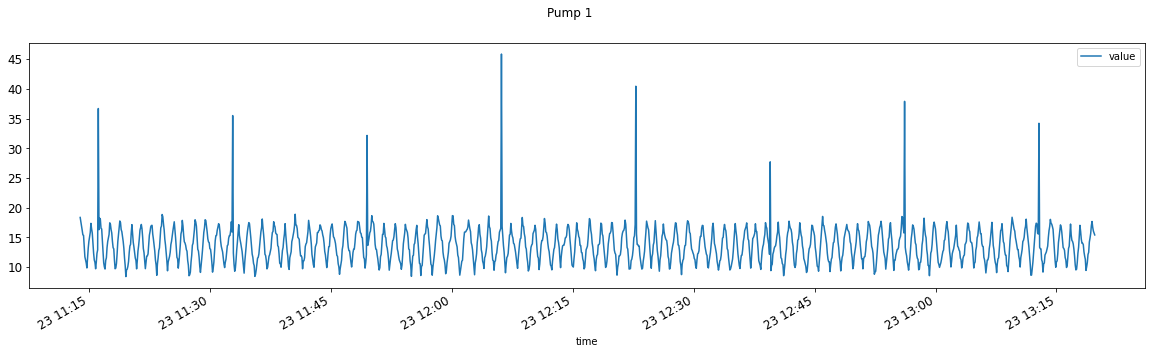

In [8]:
df1 = df.loc[df['id'] == 'pump-1']
df1 = df1.drop(columns=['id','label'])
df1.plot(figsize=(20,5),  fontsize=12,subplots=True,  title = "Pump 1")
plt.show()

Vibration pump 2: Data shows a few anomalies

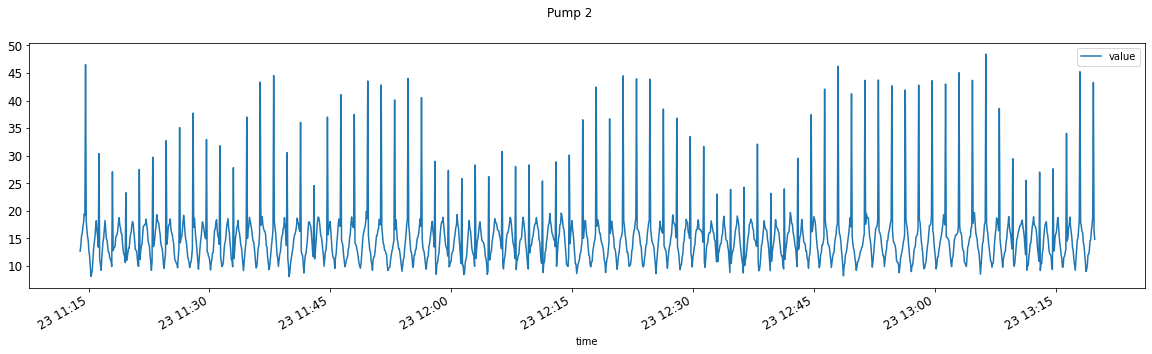

In [9]:
df2 = df.loc[df['id'] == 'pump-2']
df2 = df2.drop(columns=['id','label'])
df2.plot(figsize=(20,5),  fontsize=12,subplots=True,  title = "Pump 2")
plt.show()

### Visualize labeled data over time  <a class="anchor" id="section_1_3"></a>

- Vibration pump 1. 
- Label = 1 -> Anomanly
- The (manually) labeled data makes few more anomalies visibile.

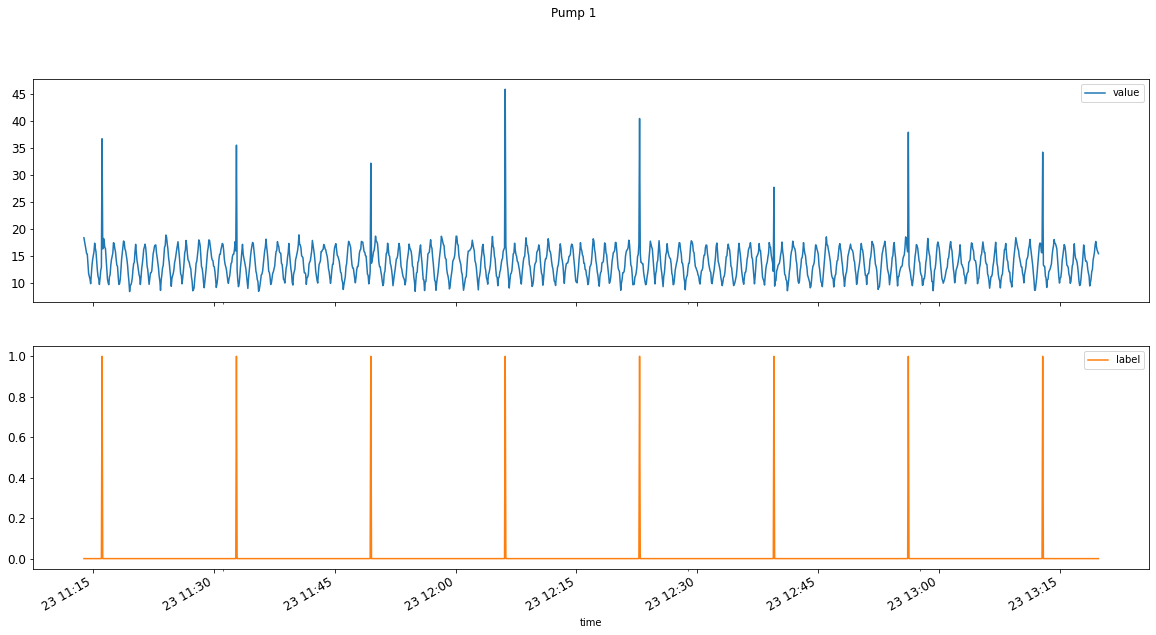

In [10]:
df1 = df.loc[df['id'] == 'pump-1']
df1 = df1.drop(columns=['id'])
df1.plot(figsize=(20,10),  fontsize=12,subplots=True,  title = "Pump 1")
plt.show()

Vibration pump 2: 
- Label = 1 -> Anomanly
- The (manually) labeled data makes few more anomalies visibile.

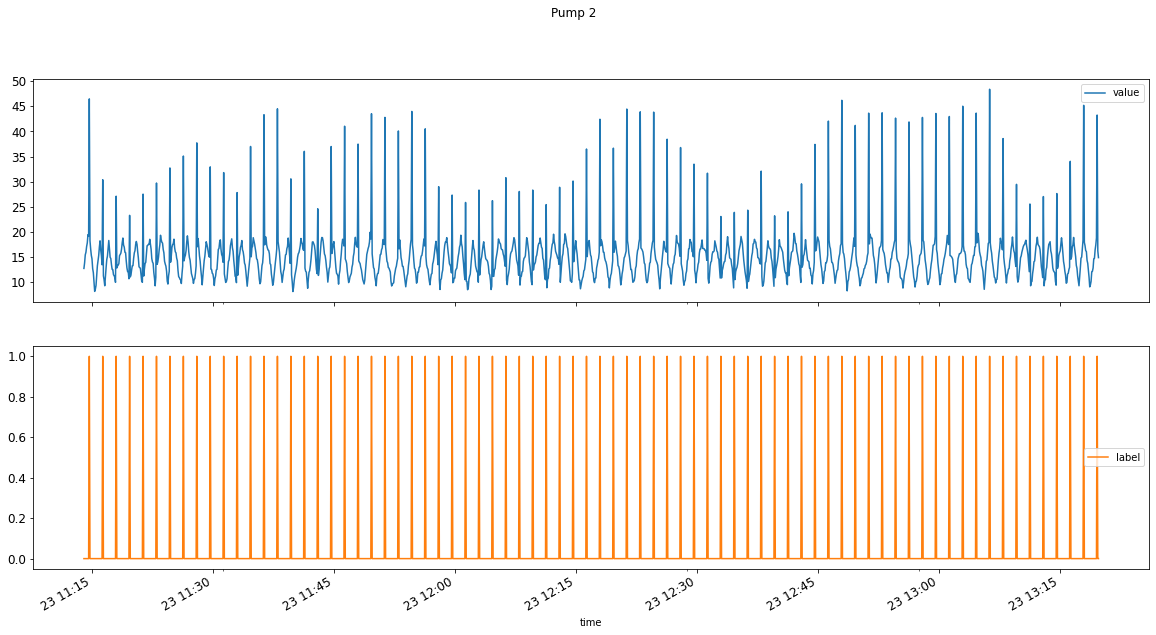

In [11]:
df2 = df.loc[df['id'] == 'pump-2']
df2 = df2.drop(columns=['id'])
df2.plot(figsize=(20,10),  fontsize=12,subplots=True, title = "Pump 2")
plt.show()

Zoom into pump 2 data:
- Here we see interesting anomalies that the machine learning mode should detect.

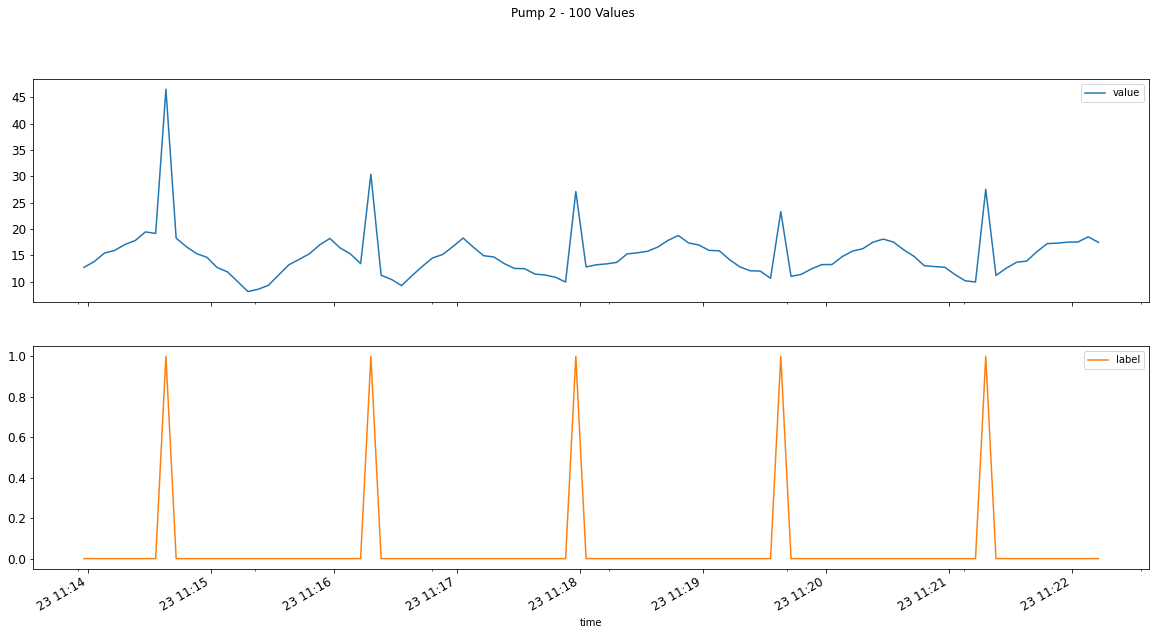

In [12]:
df21 = df2.head(100)
df21.plot(figsize=(20,10), fontsize=12,subplots=True, title = "Pump 2 - 100 Values")
plt.show()

## Data Wrangling <a class="anchor" id="chapter2"></a>

Goal: Convert time series data into small episodes that can be uses for supervised learning.

In [13]:
#
# Few helper functions
#

# Get list with column names: F1, F2, Fn, L
def get_columns(n):
    f = []
    for x in range(1,n+1):
        f.append("F"+str(x))
    f.append("L")
    return f

# Create empty data frame
def create_empty_df(n):
    d= ([0.]*n)
    d.append(0)
    dfx = pd.DataFrame([d], columns=get_columns(n))
    dfx.drop(dfx.index[0], inplace=True)
    return dfx

# Create data frame with one row
def create_df(vals: list, label: int = 0):
    if not isinstance(vals, list):
        raise TypeError
    #vals.append(label)    
    dfx = pd.DataFrame([vals+[label]], columns=get_columns(len(vals)))
    return dfx

Create a new dataframe: Rows represent the last x (length) value and the label.

```
--+-----+-----
tz value label
--+-----+-----
..  ...    0
04  6.2    0
05  7.2    0
06  3.1    0
07 12.4    1
..  ...
--+-----+-----
```

Convert to episodes with lenght = 3

```
---+----+----+---
F1   F2   F3   L
---+----+----+---
..
6.2  7.2  3.1  0
7.2  3.1 12.4  1
..
---+----+----+---
```


In [14]:
length = 5 # Episode lenght

df_epis = create_empty_df(length)

for id in df.id.unique():
    print("Convert data for: ", id)
    
    df2 = df.loc[df['id'] == id]

    epi = []
    for index, row in df2.iterrows():
        # print('%6.2f, %d' % (row['value'], row['label']))
        epi.append(row['value'])
        if len(epi) == length :
            df_row = create_df(epi,row['label'] )
            df_epis = df_epis.append(df_row, ignore_index=True)
            del(epi[0])



Convert data for:  pump-1
Convert data for:  pump-2


### Explore the new data <a class="anchor" id="section_2_1"></a>

In [15]:
df_epis.head(20)

,F1,F2,F3,F4,F5,L
0,18.340181,17.647661,16.874933,16.180807,15.407113,0
1,17.647661,16.874933,16.180807,15.407113,15.324012,0
2,16.874933,16.180807,15.407113,15.324012,13.470387,0
3,16.180807,15.407113,15.324012,13.470387,11.702384,0
4,15.407113,15.324012,13.470387,11.702384,11.176102,0
5,15.324012,13.470387,11.702384,11.176102,10.678349,0
6,13.470387,11.702384,11.176102,10.678349,9.831242,0
7,11.702384,11.176102,10.678349,9.831242,11.555063,0
8,11.176102,10.678349,9.831242,11.555063,13.197594,0
9,10.678349,9.831242,11.555063,13.197594,14.337077,0


In [16]:
df_epis.describe()

,F1,F2,F3,F4,F5,L
count,3014.000000,3014.000000,3014.000000,3014.000000,3014.000000,3014.000000
mean,14.419974,14.421438,14.430688,14.430566,14.429951,0.027870
std,4.514179,4.514390,4.544588,4.544510,4.544357,0.164627
min,8.089854,8.089854,8.089854,8.089854,8.089854,0.000000
25%,11.724137,11.724137,11.724137,11.724137,11.724137,0.000000
50%,13.961320,13.966907,13.971367,13.971367,13.971367,0.000000
75%,16.179648,16.180626,16.180626,16.180626,16.179648,0.000000
max,48.423213,48.423213,48.423213,48.423213,48.423213,1.000000


In [17]:
# Calculate number of episodes
n_episodes = df_epis.shape[0]

# Calculate number of features
n_features = df_epis.shape[1] - 1

# Calculate passing students
n_anomaly = df_epis[df_epis['L']==1].shape[0]

# TODO: Calculate failing students
n_normal = df_epis[df_epis['L']==0].shape[0]

# TODO: Calculate graduation rate
anomaly_rate = n_anomaly / float(n_episodes) *100

# Print the results
print ("Total number of episodes: {}".format(n_episodes))
print ("Number of features: {}".format(n_features))
print ("Number of episodes with anomaly: {}".format(n_anomaly))
print ("Number of episodes witManipulatehout anomaly: {}".format(n_normal))
print ("Anomaly rate in dataset: {:.2f}%".format(anomaly_rate))

Total number of episodes: 3014
Number of features: 5
Number of episodes with anomaly: 84
Number of episodes witManipulatehout anomaly: 2930
Anomaly rate in dataset: 2.79%


Let's vary the anomalies to make the model more robust

In [18]:
factor = 5 # Number of copies
dfr = df_epis.copy()
for i in range(1,factor):

    f = 0.5 + ((i - 1 ) * 0.5 / (factor-1)) # vary the anomaly by a factor 
    #print(i,f)
    
    dfi = df_epis.copy()
    dfi[f'F{length}'] = np.where(dfi['L']==1, dfi[f'F{length}']*f, dfi[f'F{length}']) # Lower the outliers
    dfr = dfr.append(dfi)
    
df_epis = dfr.copy()

In [19]:
# Calculate number of episodes
n_episodes = df_epis.shape[0]

# Calculate number of features
n_features = df_epis.shape[1] - 1

# Calculate passing students
n_anomaly = df_epis[df_epis['L']==1].shape[0]

# TODO: Calculate failing students
n_normal = df_epis[df_epis['L']==0].shape[0]

# TODO: Calculate graduation rate
anomaly_rate = n_anomaly / float(n_episodes) *100

# Print the results
print ("Total number of episodes: {}".format(n_episodes))
print ("Number of features: {}".format(n_features))
print ("Number of episodes with anomaly: {}".format(n_anomaly))
print ("Number of episodes without anomaly: {}".format(n_normal))
print ("Anomaly rate in dataset: {:.2f}%".format(anomaly_rate))

Total number of episodes: 15070
Number of features: 5
Number of episodes with anomaly: 420
Number of episodes without anomaly: 14650
Anomaly rate in dataset: 2.79%


### Save Training data to CSV <a class="anchor" id="section_2_2"></a>

In [20]:
df_epis.to_csv ('sensor-training-data.csv', index = False, header=True, float_format='%.2f')

# Prepare the data for modeling, training and testing <a class="anchor" id="chapter3"></a>

- Identify feature and target columns
- Training and Testing Data Split

## Identify feature and target columns <a class="anchor" id="section_3_1"></a>

In [21]:
# Extract feature columns
feature_cols = list(df_epis.columns[:-1])

# Extract target column 'label'
target_col = df_epis.columns[-1] 

# Show the list of columns
print ("Feature columns:\n{}".format(feature_cols))
print ("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = df_epis[feature_cols]
y_all = df_epis[target_col]

# Show the feature information by printing the first five rows
print ("\nFeature values:")
print (X_all.head())

Feature columns:
['F1', 'F2', 'F3', 'F4', 'F5']

Target column: L

Feature values:
          F1         F2         F3         F4         F5
0  18.340181  17.647661  16.874933  16.180807  15.407113
1  17.647661  16.874933  16.180807  15.407113  15.324012
2  16.874933  16.180807  15.407113  15.324012  13.470387
3  16.180807  15.407113  15.324012  13.470387  11.702384
4  15.407113  15.324012  13.470387  11.702384  11.176102


## Training and Testing Data Split <a class="anchor" id="section_3_2"></a>

Statistical Models

In [22]:
X_train, X_test, y_train, y_test = train_test_split( X_all, y_all, test_size=0.33, random_state=42)


# Show the results of the split
printmd("Training set has {} samples.".format(X_train.shape[0]))
printmd("Testing set has {} samples.".format(X_test.shape[0]))

printmd("Anomaly rate of the training set: {:.2f}%".format(100 * (y_train == 1).mean()))
printmd("Anomaly rate of the testing set: {:.2f}%".format(100 * (y_test == 1).mean()))

Training set has 10096 samples.

Testing set has 4974 samples.

Anomaly rate of the training set: 2.76%

Anomaly rate of the testing set: 2.83%

## Training and Evaluating Statistical ML Models
- Setup helper functions

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing supervised learning models. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [23]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target.values, y_pred)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    f1_score_test = predict_labels(clf, X_test, y_test)
    print ("F1 score for test set: {:.4f}.".format(f1_score_test))
    
    return {
        "Model": clf.__class__.__name__,
        "Model type": "Statistical model",
        "F1 score": f1_score_test
    }
    

### Testing Model Performance 

Let's test 3 supervised learning models:
- A) Decision Trees
- B) Support Vector Machines (SVM)
- C) Gaussian Naive Bayes (GaussianNB)
 

In [24]:
my_random_seed = 42

# Initialize the three models
clf_A = DecisionTreeClassifier(random_state=my_random_seed)
clf_B = SVC(random_state=my_random_seed)
clf_C = GaussianNB()

#Collect results from each model
summary_results = []

# loop thru models, then thru train sizes
for clf in [clf_A, clf_B, clf_C]:
    print ("\n{}: \n".format(clf.__class__.__name__))
    summary_results.append(train_predict(clf, X_train, y_train, X_test, y_test))
        
                    

for clf in [clf_A, clf_B, clf_C]:
    print ('\nReport for {}:\n'.format(clf.__class__.__name__))
    print (classification_report(y_test, clf.predict(X_test)))
    print ('-'*52)


DecisionTreeClassifier: 

Training a DecisionTreeClassifier using a training set size of 10096. . .
Trained model in 0.0390 seconds
Made predictions in 0.0022 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0021 seconds.
F1 score for test set: 0.9783.

SVC: 

Training a SVC using a training set size of 10096. . .
Trained model in 0.0791 seconds
Made predictions in 0.0352 seconds.
F1 score for training set: 0.9472.
Made predictions in 0.0189 seconds.
F1 score for test set: 0.9278.

GaussianNB: 

Training a GaussianNB using a training set size of 10096. . .
Trained model in 0.0031 seconds
Made predictions in 0.0021 seconds.
F1 score for training set: 0.8423.
Made predictions in 0.0017 seconds.
F1 score for test set: 0.7845.

Report for DecisionTreeClassifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4833
           1       1.00      0.96      0.98       141

    accuracy                           1.00     

The **precision** is the ratio ```tp / (tp + fp)``` where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The **recall** is the ratio ```tp / (tp + fn)``` where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The **F1 score** can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

```F1 = 2 * (precision * recall) / (precision + recall)```

The **support** is the number of occurrences of each class in ```y_true```.

Source:
[sklearn.metrics.precision_recall_fscore_support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html) [sklearn.metrics.f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

## Training and Evaluating Deep Learning Model: LSTM AutoEncoder

In [25]:
# Create Keras callbacks
losses = []

def handleLoss(loss):
    global losses
    losses+=[loss]
    print(loss)
       
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))
        self.losses = []

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch + 1, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch + 1, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

In [26]:
# Create model

def get_model(X):
    """Get model."""
    model = keras.Sequential()

    model.add(keras.layers.LSTM(units=16,
                                input_shape=(X.shape[1],X.shape[2]),
                                activation='relu', return_sequences=True))
    model.add(keras.layers.LSTM(units=4, activation='relu'))
    model.add(keras.layers.RepeatVector(n=X.shape[1]))
    model.add(keras.layers.LSTM(units=4, activation='relu', return_sequences=True))
    model.add(keras.layers.LSTM(units=16, activation='relu', return_sequences=True))
    model.add(
      keras.layers.TimeDistributed(
        keras.layers.Dense(units=X.shape[2])
      )
    )

    model.compile(loss='mae', optimizer='adam')
    
    model.summary()

    return model

In [27]:
# Create helper functions
def train(x_train_data, tot_epochs, selected_batch_size):
    """Train model."""
    model = get_model(X=x_train_data)
    history = model.fit(
        x_train_data,
        x_train_data,
        epochs=tot_epochs,
        batch_size=selected_batch_size,
        validation_split=0.05,
        verbose=1,
        shuffle=False,
        callbacks=[CustomCallback()]
    )
    
    return history, model

def predict(model, data):
    """Predict value."""
    predicted_value =  model.predict(data)


In [28]:
healthy_data = df.loc[(df['label'] == 0)]
anomalies_data = df.loc[(df['label'] == 1)]

print(f"Total number of healthy samples is {healthy_data.shape[0]}")
percentage_anomalies = anomalies_data.shape[0]/df.shape[0]*100
print(f"Total number of samples with anomalies is {anomalies_data.shape[0]} -> {percentage_anomalies:.2f}%")

Total number of healthy samples is 2938
Total number of samples with anomalies is 84 -> 2.78%


In [29]:
# X_all_healthy = pd.DataFrame(healthy_data['value'].values)
# y_all_healthy = pd.DataFrame(healthy_data['label'].values)

# X_all_anomalies = pd.DataFrame(anomalies_data['value'].values)
# y_all_anomalies = pd.DataFrame(anomalies_data['label'].values)

df_epis_healthy = df_epis[df_epis['L'] == 0]
df_epis_anomalies = df_epis[df_epis['L'] == 1]

X_all_healthy = df_epis_healthy[feature_cols]
y_all_healthy = df_epis_healthy[target_col]

X_all_anomalies = df_epis_anomalies[feature_cols]
y_all_anomalies = df_epis_anomalies[target_col]

Deep Learning Model: LSTM Autoencoder

In [70]:
# Scale data

my_scaler = MinMaxScaler(feature_range=(0, 1))
my_scaler.fit(X_all_healthy)
X_all_healthy_scaled = pd.DataFrame(my_scaler.transform(X_all_healthy))
X_all_anomalies_scaled = pd.DataFrame(my_scaler.transform(X_all_anomalies))


# Split

X_train_healthy_scaled, X_test_healthy_scaled, y_train_healthy, y_test_healthy = train_test_split( X_all_healthy_scaled, y_all_healthy, test_size=0.15, random_state=42)

# Show the results of the split
printmd("**Training healthy** set has **{}** samples.".format(X_train_healthy.shape[0]))
printmd("**Testing healthy** set has **{}** samples.".format(X_test_healthy.shape[0]))

**Training healthy** set has **12452** samples.

**Testing healthy** set has **2198** samples.

### Normalize the data

When working with neural networks it is always good to scale data to a range between zero and one. Because we are planning to turn this notebook into a real-time anomaly detector for IoT sensor date we are defining a function instead of transforming the data so that we can make use of the transformer at later stage.

In [40]:
def scaleData(data, use_normalized):
    # normalize features
    if use_normalized:
        scaler = MinMaxScaler(feature_range=(0, 1))
        return pd.DataFrame(scaler.fit_transform(data))
    
    return data

use_normalized = False

if use_normalized:
    print ("Using normalized/scaled data!")


#X_train_scaled = scaleData(X_train, use_normalized=use_normalized)
#X_test_scaled = scaleData(X_test, use_normalized=use_normalized)

#X_train_healthy_scaled = scaleData(X_train_healthy, use_normalized=use_normalized)
#X_test_healthy_scaled = scaleData(X_test_healthy, use_normalized=use_normalized)

#X_all_anomalies_scaled = scaleData(X_all_anomalies, use_normalized=use_normalized)

### Reshape inputs for LSTM (samples, timestamps, features)

In [41]:
x_train_healthy = X_train_healthy_scaled.values.reshape(X_train_healthy_scaled.shape[0], 1, X_train_healthy_scaled.shape[1])
print ("Training set healthy shape: {}".format(x_train_healthy.shape))

x_test_healthy = X_test_healthy_scaled.values.reshape(X_test_healthy_scaled.shape[0], 1, X_test_healthy_scaled.shape[1])
print ("Test set healthy shape: {}".format(x_test_healthy.shape))

x_all_anomalies = X_all_anomalies_scaled.values.reshape(X_all_anomalies_scaled.shape[0], 1, X_all_anomalies_scaled.shape[1])
print ("Set anomalies shape: {}".format(x_all_anomalies.shape))

Training set healthy shape: (12452, 1, 5)
Test set healthy shape: (2198, 1, 5)
Set anomalies shape: (420, 1, 5)


#### Train Deep learning model

In [45]:
tot_epochs = 100
selected_batch_size = 1

history, lstm_autoencoder = train(
    x_train_data=x_train_healthy,
    tot_epochs=tot_epochs,
    selected_batch_size=selected_batch_size
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 16)             1408      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 5)              85        
Total params: 3,317
Trainable params: 3,317
Non-trainable params: 0
______________________________________________________

11819/11829 [============================>.] - ETA: 0s - loss: 0.0190Start testing; got log keys: []
Stop testing; got log keys: ['loss']
End epoch 21 of training; got log keys: ['loss', 'val_loss']
11829/11829 [==============================] - 24s 2ms/step - loss: 0.0190 - val_loss: 0.0178
Start epoch 22 of training; got log keys: []
Epoch 22/100
11819/11829 [============================>.] - ETA: 0s - loss: 0.0190Start testing; got log keys: []
Stop testing; got log keys: ['loss']
End epoch 22 of training; got log keys: ['loss', 'val_loss']
11829/11829 [==============================] - 25s 2ms/step - loss: 0.0190 - val_loss: 0.0183
Start epoch 23 of training; got log keys: []
Epoch 23/100
11799/11829 [============================>.] - ETA: 0s - loss: 0.0190Start testing; got log keys: []
Stop testing; got log keys: ['loss']
End epoch 23 of training; got log keys: ['loss', 'val_loss']
11829/11829 [==============================] - 23s 2ms/step - loss: 0.0190 - val_loss: 0.0179
Start

Start epoch 45 of training; got log keys: []
Epoch 45/100
11826/11829 [============================>.] - ETA: 0s - loss: 0.0134Start testing; got log keys: []
Stop testing; got log keys: ['loss']
End epoch 45 of training; got log keys: ['loss', 'val_loss']
11829/11829 [==============================] - 35s 3ms/step - loss: 0.0134 - val_loss: 0.0122
Start epoch 46 of training; got log keys: []
Epoch 46/100
11822/11829 [============================>.] - ETA: 0s - loss: 0.0134Start testing; got log keys: []
Stop testing; got log keys: ['loss']
End epoch 46 of training; got log keys: ['loss', 'val_loss']
11829/11829 [==============================] - 35s 3ms/step - loss: 0.0134 - val_loss: 0.0123
Start epoch 47 of training; got log keys: []
Epoch 47/100
11825/11829 [============================>.] - ETA: 0s - loss: 0.0133Start testing; got log keys: []
Stop testing; got log keys: ['loss']
End epoch 47 of training; got log keys: ['loss', 'val_loss']
11829/11829 [============================

11820/11829 [============================>.] - ETA: 0s - loss: 0.0127Start testing; got log keys: []
Stop testing; got log keys: ['loss']
End epoch 68 of training; got log keys: ['loss', 'val_loss']
11829/11829 [==============================] - 37s 3ms/step - loss: 0.0127 - val_loss: 0.0113
Start epoch 69 of training; got log keys: []
Epoch 69/100
11822/11829 [============================>.] - ETA: 0s - loss: 0.0127Start testing; got log keys: []
Stop testing; got log keys: ['loss']
End epoch 69 of training; got log keys: ['loss', 'val_loss']
11829/11829 [==============================] - 36s 3ms/step - loss: 0.0127 - val_loss: 0.0120
Start epoch 70 of training; got log keys: []
Epoch 70/100
11822/11829 [============================>.] - ETA: 0s - loss: 0.0127Start testing; got log keys: []
Stop testing; got log keys: ['loss']
End epoch 70 of training; got log keys: ['loss', 'val_loss']
11829/11829 [==============================] - 37s 3ms/step - loss: 0.0127 - val_loss: 0.0125
Start

Start epoch 92 of training; got log keys: []
Epoch 92/100
11827/11829 [============================>.] - ETA: 0s - loss: 0.0124Start testing; got log keys: []
Stop testing; got log keys: ['loss']
End epoch 92 of training; got log keys: ['loss', 'val_loss']
11829/11829 [==============================] - 42s 4ms/step - loss: 0.0124 - val_loss: 0.0113
Start epoch 93 of training; got log keys: []
Epoch 93/100
11826/11829 [============================>.] - ETA: 0s - loss: 0.0123Start testing; got log keys: []
Stop testing; got log keys: ['loss']
End epoch 93 of training; got log keys: ['loss', 'val_loss']
11829/11829 [==============================] - 45s 4ms/step - loss: 0.0123 - val_loss: 0.0110
Start epoch 94 of training; got log keys: []
Epoch 94/100
11827/11829 [============================>.] - ETA: 0s - loss: 0.0123Start testing; got log keys: []
Stop testing; got log keys: ['loss']
End epoch 94 of training; got log keys: ['loss', 'val_loss']
11829/11829 [============================

Plot loss

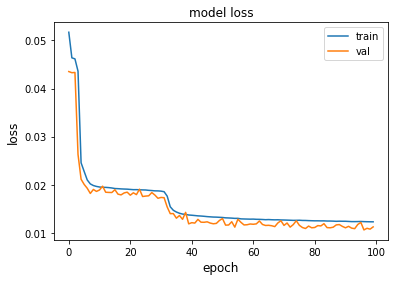

In [46]:
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

Choosing a treshold

<Figure size 432x288 with 0 Axes>

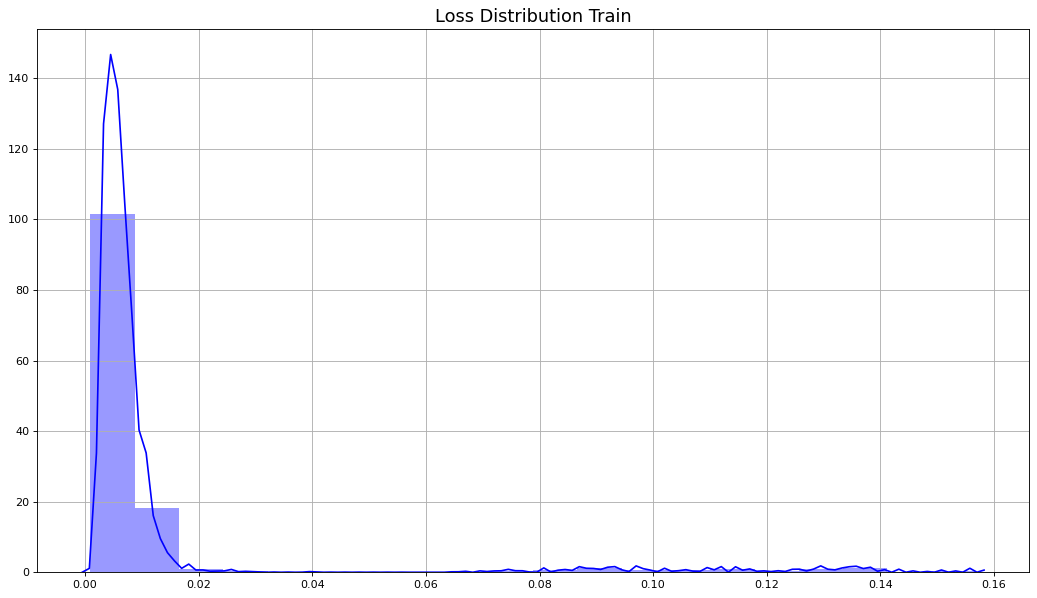

In [47]:
x_train_pred = lstm_autoencoder.predict(x_train_healthy)
x_train_pred_ = x_train_pred.reshape(x_train_pred.shape[0], x_train_pred.shape[2])
x_train_healthy_ = x_train_healthy.reshape(x_train_healthy.shape[0], x_train_healthy.shape[2])
train_mae_loss = np.mean(np.abs(x_train_pred_ - x_train_healthy_), axis=1)
scored_d = {}

plt.figure()
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution Train', fontsize=16)
plt.grid()
sns.distplot(train_mae_loss,
             bins = 20, 
             kde= True,
            color = 'blue');
# plt.xlim([0.0,.5])

In [69]:
x_train_pred

array([[[0.69931096, 0.13119423, 0.08708891, 0.06368582, 0.1923532 ]],

       [[0.13152179, 0.10064626, 0.07188664, 0.0427068 , 0.08192886]],

       [[0.10905073, 0.13332745, 0.1461825 , 0.176416  , 0.7148006 ]],

       ...,

       [[0.05215614, 0.09881234, 0.13592097, 0.16172725, 0.6209262 ]],

       [[0.137778  , 0.17249343, 0.19754517, 0.1994286 , 0.6748035 ]],

       [[0.04057244, 0.07630876, 0.10267112, 0.14352405, 0.63093394]]],
      dtype=float32)

Using the **threshold**, we can turn the problem into a simple binary classification task:

If the reconstruction loss for an example is below the threshold, we’ll classify it as healthy.
Alternatively, if the loss is higher than the threshold, we’ll classify it as an anomaly.

In [86]:
threshold = 0.025


<Figure size 432x288 with 0 Axes>

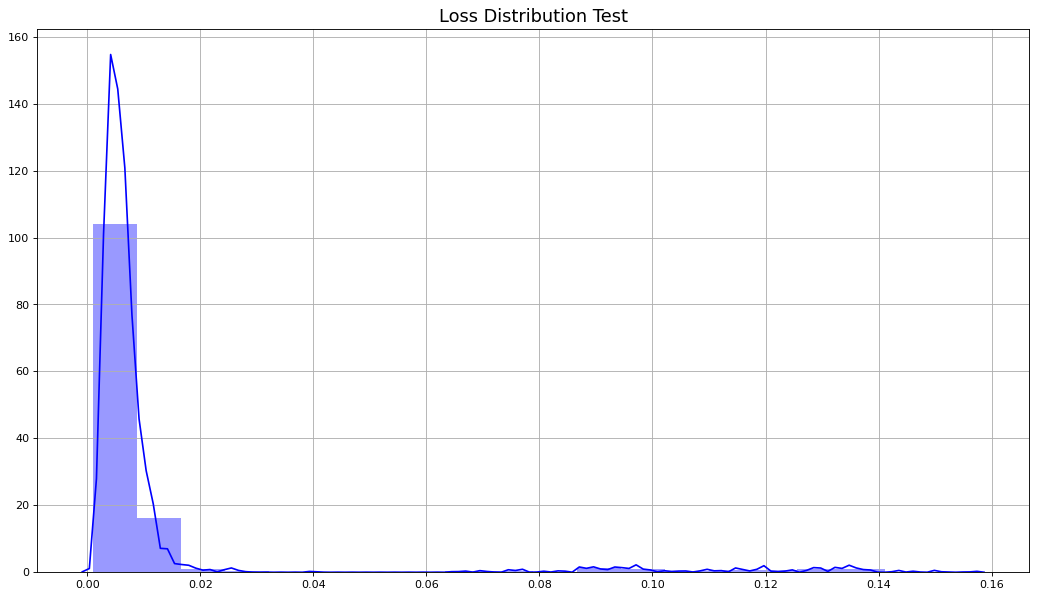

In [87]:
x_test_pred = lstm_autoencoder.predict(x_test_healthy)

x_test_pred_ = x_test_pred.reshape(x_test_pred.shape[0], x_test_pred.shape[2])
x_test_healthy_ = x_test_healthy.reshape(x_test_healthy.shape[0], x_test_healthy.shape[2])

test_mae_loss = np.mean(np.abs(x_test_pred_ - x_test_healthy_), axis=1)

scored_test = {}
scored_test['Loss_mae'] = test_mae_loss
scored_test['Threshold'] = threshold
scored_t = pd.DataFrame(scored_test)
scored_t['Healthy_pred'] = scored_t['Loss_mae'] < scored_t['Threshold']
scored_t['Healthy_pred_int'] = scored_t['Healthy_pred'].astype(int)

scored_t['Target'] = y_test_healthy.values
scored_t.describe()

plt.figure()
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution Test', fontsize=16)
plt.grid()
sns.distplot(test_mae_loss,
             bins = 20, 
             kde= True,
            color = 'blue');
# plt.xlim([0.0,.5])

In [88]:
no_anomalies = scored_t[scored_t['Healthy_pred_int'] == 0]
percentage_identified = no_anomalies.shape[0]/scored_t.shape[0]
print(f"Percentage of anomalies in healthy data identified: {percentage_identified*100:.2f}%")

Percentage of anomalies in healthy data identified: 5.55%


In [89]:
start = time()
x_all_pred = lstm_autoencoder.predict(x_all_anomalies)
end = time()

# Print and return results
print ("Made predictions in {:.4f} seconds.".format(end - start))

x_all_pred_ = x_all_pred.reshape(x_all_pred.shape[0], x_all_pred.shape[2])
x_all_anomalies_ = x_all_anomalies.reshape(x_all_anomalies.shape[0], x_all_anomalies.shape[2])

all_mae_loss = np.mean(np.abs(x_all_pred_ - x_all_anomalies_), axis=1)

scored_test = {}
scored_test['Loss_mae'] = all_mae_loss
scored_test['Threshold'] = threshold
scored_a = pd.DataFrame(scored_test)
scored_a['Anomaly_pred'] = scored_a['Loss_mae'] > scored_a['Threshold']
scored_a['Anomaly_pred_int'] = scored_a['Anomaly_pred'].astype(int)

scored_a['Target'] = y_all_anomalies.values
scored_a.head()

Made predictions in 0.0535 seconds.


,Loss_mae,Threshold,Anomaly_pred,Anomaly_pred_int,Target
0,0.460199,0.025,True,1,1
1,0.261737,0.025,True,1,1
2,0.386985,0.025,True,1,1
3,0.484011,0.025,True,1,1
4,0.398341,0.025,True,1,1


In [90]:
scored_a.describe()

,Loss_mae,Threshold,Anomaly_pred_int,Target
count,420.000000,4.200000e+02,420.000000,420.0
mean,0.165257,2.500000e-02,0.816667,1.0
std,0.135494,1.945207e-16,0.387401,0.0
min,0.006619,2.500000e-02,0.000000,1.0
25%,0.037137,2.500000e-02,1.000000,1.0
50%,0.140439,2.500000e-02,1.000000,1.0
75%,0.261514,2.500000e-02,1.000000,1.0
max,0.510758,2.500000e-02,1.000000,1.0


<Figure size 432x288 with 0 Axes>

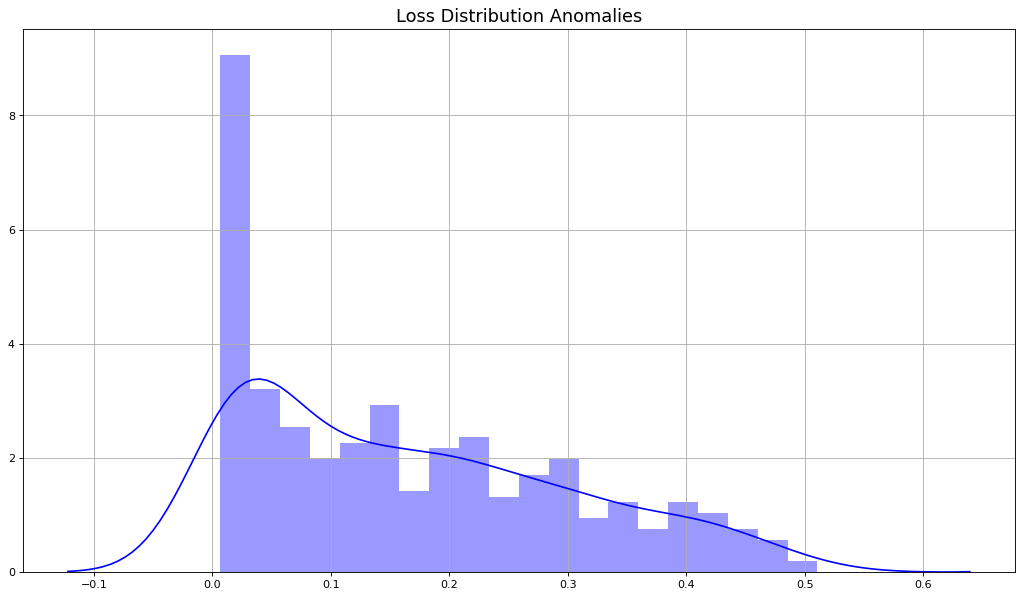

In [91]:
plt.figure()
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution Anomalies', fontsize=16)
plt.grid()
sns.distplot(all_mae_loss,
             bins = 20, 
             kde= True,
            color = 'blue');
# plt.xlim([0.0,.5])

In [92]:
anwith_anomalies = scored_a[scored_a['Anomaly_pred_int'] == 1]
percentage_identified = with_anomalies.shape[0]/scored_a.shape[0]
printmd(f"Percentage of anomalies identified in anomalies set: **{percentage_identified*100:.2f}%**")

print(classification_report(scored_a['Target'], scored_a['Anomaly_pred_int']))

f1_score_ = f1_score(scored_a['Target'], scored_a['Anomaly_pred_int'])
printmd("F1 score for anomalies set: **{:.4f}**.".format(f1_score_))

# Deep Learning models (Supervised Learning)

summary_results.append(
    {
        "Model": "LSTM Autoencoder",
        "Model type": "Deep Learning model",
        "F1 score": f1_score_
    }
)

Percentage of anomalies identified in anomalies set: **85.71%**

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.82      0.90       420

    accuracy                           0.82       420
   macro avg       0.50      0.41      0.45       420
weighted avg       1.00      0.82      0.90       420



/home/sbergste/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score for anomalies set: **0.8991**.

In [93]:
results = pd.DataFrame(summary_results)
results.sort_values(by=['F1 score'], ascending=False)

,Model,Model type,F1 score
0,DecisionTreeClassifier,Statistical model,0.978261
1,SVC,Statistical model,0.927757
6,LSTM Autoencoder,Deep Learning model,0.923077
7,LSTM Autoencoder,Deep Learning model,0.899083
4,LSTM Autoencoder,Deep Learning model,0.875502
3,LSTM Autoencoder,Deep Learning model,0.830084
2,GaussianNB,Statistical model,0.784483
5,LSTM Autoencoder,Deep Learning model,0.588235


**Brief interpretation:**

From the results in the above table we can see that using Deep Learning Model for Anomaly Detection gives the best results in terms of predictions. 

Important to notice that for the model selected no Hyperparameter Tuning was performed.

Let's save and load the model just to double check that it works.

In [ ]:
from joblib import dump, load
from pathlib import Path

current_path = Path().cwd()

filepath = current_path.joinpath('ml-models/anomaly-detection/lstm_autoencoder_model')

tf.keras.models.save_model(
    lstm_autoencoder, filepath, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None
)

# Validate that the model can be loaded

# load the model from disk
loaded_model = tf.keras.models.load_model(filepath)
x_all_pred = loaded_model.predict(x_all_anomalies)
all_mae_loss = np.mean(np.abs(x_all_pred - x_all_anomalies), axis=1)

scored_test = {}
scored_test['Loss_mae'] = all_mae_loss[:, 0]
scored_test['Threshold'] = threshold
scored_a = pd.DataFrame(scored_test)
scored_a['Anomaly_pred'] = scored_a['Loss_mae'] > scored_a['Threshold']
scored_a['Anomaly_pred_int'] = scored_a['Anomaly_pred'].astype(int)

scored_a['Target'] = y_all_anomalies.values

with_anomalies = scored_a[scored_a['Anomaly_pred_int'] == 1]
percentage_identified = with_anomalies.shape[0]/scored_a.shape[0]
print(f"Percentage of anomalies identified: {percentage_identified*100:.2f}%")

print(classification_report(scored_a['Target'], scored_a['Anomaly_pred_int']))

f1_score_ = f1_score(scored_a['Target'], scored_a['Anomaly_pred_int'])
print("Score is: {:.4f}.".format(f1_score_))

## Prototype class for Seldon model serving
For serving the model using Seldon, we need to implement a simple call with an constructor and predict method. Let's try it out here:
### Statistical ML Model (DecisionTree)

In [ ]:
import os, sys
from joblib import dump, load

class AnomalyDetection(object):
    def __init__(self):
        print("Initializing...")
        self.model_file = os.environ.get('MODEL_FILE', 'model.joblib')

        print("Load modelfile: %s" % (self.model_file))
        self.clf = load(open(self.model_file, 'rb'))

    def predict(self, X, feature_names):
        print("Predict features: ", X) 

        prediction = self.clf.predict(X)
        print("Prediction: " , prediction)
        
        return prediction

In [ ]:
p = AnomalyDetection()
    
X = np.asarray([[16.1,  15.40,  15.32,  13.47,  17.70]], dtype=np.float32)
prediction = p.predict(X, "")

X = np.asarray([[1.0,  1.,  1.,  1.,  1.]], dtype=np.float32)
prediction = p.predict(X, "" )

X = np.asarray([[10.0,  10.0,  10.0,  10.0,  10.0]], dtype=np.float32)
prediction = p.predict(X, "")



### Deep Learning Model (LSTM Autoencoder)

In [ ]:
def scaleData(data, use_normalized):
    # normalize features
    if use_normalized:
        scaler = MinMaxScaler(feature_range=(0, 1))
        return pd.DataFrame(scaler.fit_transform(data))
    
    return data

use_normalized = True

if use_normalized:
    print ("Using normalized/scaled data!")

X_train_scaled = scaleData(X_train, use_normalized=use_normalized)

In [ ]:
from pathlib import Path

# ML Framework and High Level API
import tensorflow as tf
from tensorflow import keras

import numpy as np

class AnomalyDetection2(object):
    def __init__(self):
        
        print("Initializing...")
        current_path = Path().cwd()

        filepath = current_path.joinpath('ml-models/anomaly-detection/lstm_autoencoder_model')

        # load the model from disk
        self.loaded_model = tf.keras.models.load_model(filepath)


    def predict(self, X, feature_names):
        
        threshold = 0.030
        
        print("Predict features: ", X) 
        
        scaler = MinMaxScaler(feature_range=(0, 1))

        
        #  - Scale to 0-1 using scaler.fit_transform
        #  - reshape the data so that scaler accepts the data
        #  - reshape again into original share
        #  - Add required dimension
        
        #input_samples = np.array([ scaler.fit_transform(X[0].reshape(-1, 1)).reshape(1, -1) ])
        input_samples = np.array([ X ])
        
        # Predict
        prediction = self.loaded_model.predict(input_samples)
        print("prediction: " , prediction)
                
        # Mean aboslute loss
        mae_loss = np.mean(np.abs(prediction - input_samples))

        print("mae_loss: " , mae_loss)
        
        if mae_loss < threshold:
            r = [0]
        else:
            r = [1]
     
        print(r)
        
        return r

In [ ]:
p2 = AnomalyDetection2()
    
X = np.asarray([[16.1,  15.40,  15.32,  13.47,  17.70]], dtype=np.float32)
prediction = p2.predict(X, "" )

X = np.asarray([[1.0,  1.,  1.,  1.,  1.]], dtype=np.float32)
prediction = p2.predict(X, "" )

X = np.asarray([[10.0,  10.0,  10.0,  10.0,  10.0]], dtype=np.float32)
prediction = p2.predict(X, "" )


In [ ]:
i = np.array([X])
p= p2.loaded_model.predict(i)

In [ ]:
p

In [ ]:
i

In [ ]:
p - i

In [ ]:
np.abs(p - i)

In [ ]:
np.mean(np.abs(p - i), axis=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
scaler.fit_transform(i[0])

In [ ]:
i

In [ ]:
i

In [ ]:
i[0]

In [ ]:
.reshape(-1, 1)scaler = MinMaxScaler()

In [ ]:
scaler.fit(i[0])

In [ ]:
scaler.transform(i[0])

In [ ]:
scaler.data_max_

In [ ]:
i[0,0]

In [ ]:
scaler.fit(i[0,0])

In [ ]:
r = i[0,0].reshape(-1, 1)

In [ ]:
r

In [ ]:
scaler.fit_transform(r)

In [ ]:
s = scaler.fit_transform(r)

In [ ]:
s.reshape(1, -1)

In [ ]:
XX = np.asarray([[16.1,  15.40,  15.32,  13.47,  17.70]], dtype=np.float32)

In [ ]:
XX.shape

In [ ]:
XX[0].reshape(-1, 1)

In [ ]:
input_samples = np.array([ scaler.fit_transform(XX[0].reshape(-1, 1)).reshape(1, -1) ])

In [ ]:
input_samples